In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Load dataset and configure plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load data
df = pd.read_csv('../sofifa_players.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")
print(f"\nFirst few rows:")
df.head(3)

Dataset shape: (5816, 49)

Columns: ['Name', 'Age', 'Overall', 'Potential', 'Team', 'Value_Raw', 'Wage_Raw', 'Value_Numeric', 'Wage_Numeric', 'Player_URL']...

First few rows:


,Name,Age,Overall,Potential,Team,Value_Raw,Wage_Raw,Value_Numeric,Wage_Numeric,Player_URL,...,Standing_tackle,Sliding_tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,Positions,Marking,Positioning
0,Dro,17,62,85,FC Barcelona,€1.2M,€8K,1200000.0,8000.0,/player/80674/pedro-fernandez/260016/,...,33.0,35.0,10.0,6.0,12.0,12.0,9.0,"CAM, LM, CM, SUB",NaN,NaN
1,J. Jacquet,19,76,84,Stade Rennais FC,€15M,€17K,15000000.0,17000.0,/player/278903/jeremy-jacquet/260016/,...,78.0,75.0,10.0,11.0,10.0,14.0,13.0,CB,NaN,NaN
2,C. Bassey,25,78,81,Fulham FC,€16.5M,€69K,16500000.0,69000.0,/player/241436/calvin-bassey/260016/,...,78.0,76.0,9.0,7.0,5.0,8.0,7.0,"CB, LCB",NaN,NaN


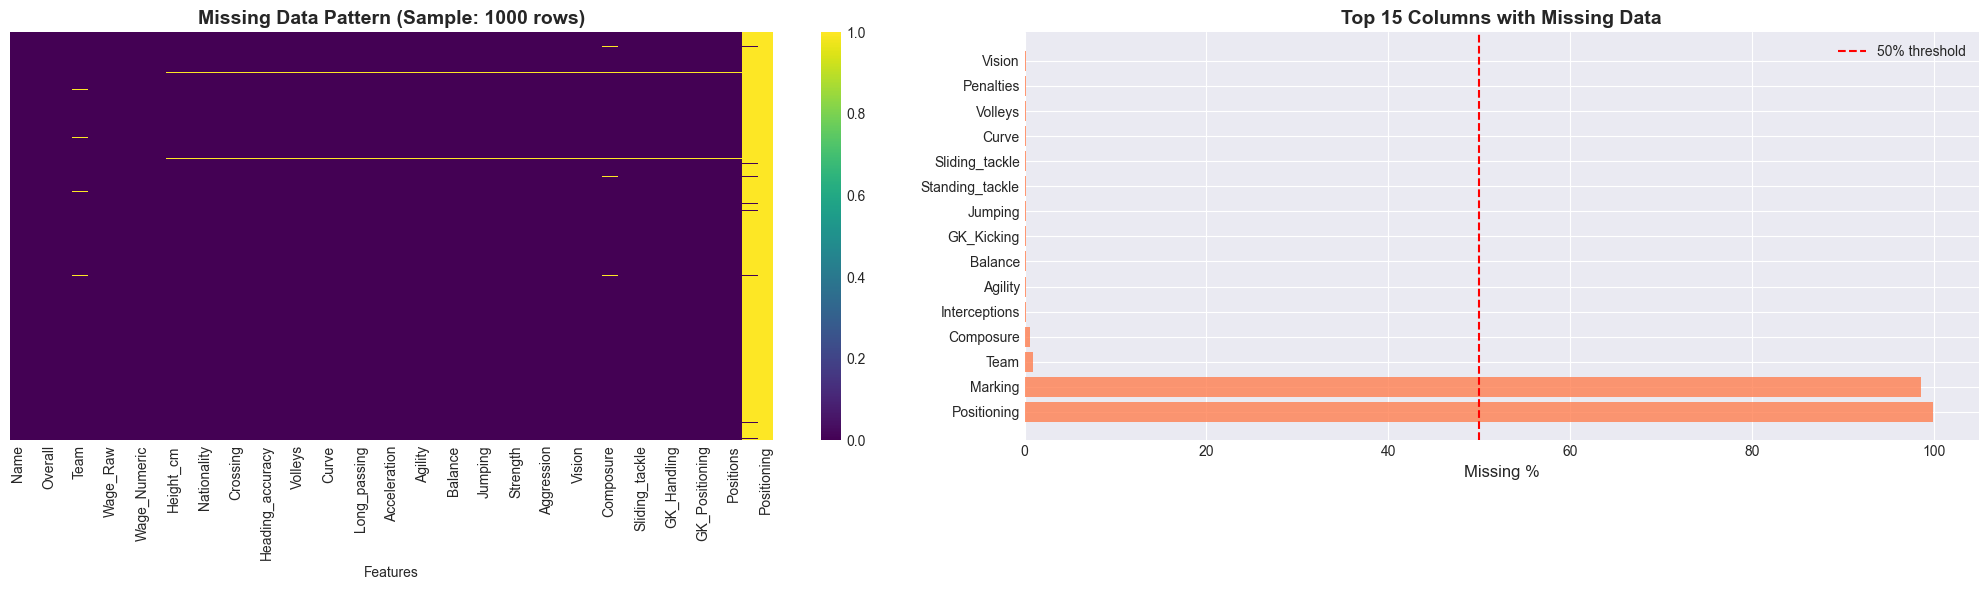


Missing Data Summary:
Total columns with missing data: 40
Columns to drop (>50% missing): 2


In [26]:
# 1. MISSING DATA ANALYSIS
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Heatmap (sample if too large)
sample_size = min(1000, len(df))
axes[0].set_title(f'Missing Data Pattern (Sample: {sample_size} rows)', fontsize=14, weight='bold')
sns.heatmap(df.sample(sample_size).isnull(), cbar=True, yticklabels=False,
            cmap='viridis', ax=axes[0])
axes[0].set_xlabel('Features')

# Missing percentage bar chart
missing_pct = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_pct_top = missing_pct[missing_pct > 0].head(15)

if len(missing_pct_top) > 0:
    axes[1].barh(missing_pct_top.index, missing_pct_top.values, color='coral', alpha=0.8)
    axes[1].set_xlabel('Missing %', fontsize=12)
    axes[1].set_title('Top 15 Columns with Missing Data', fontsize=14, weight='bold')
    axes[1].axvline(50, color='red', linestyle='--', label='50% threshold')
    axes[1].legend()
else:
    axes[1].text(0.5, 0.5, 'No Missing Data!', ha='center', va='center',
                 fontsize=20, color='green', weight='bold')
    axes[1].set_title('Missing Data Status', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

print("\nMissing Data Summary:")
print(f"Total columns with missing data: {(df.isnull().sum() > 0).sum()}")
print(f"Columns to drop (>50% missing): {(missing_pct > 50).sum()}")

**Insight:** Thiếu dữ liệu tập trung ở nhóm chỉ số GK và một vài cột hiếm; các cột >50% missing nên cân nhắc drop, còn lại dùng imputation (median/mode) và có thể thêm cờ missing cho GK stats.

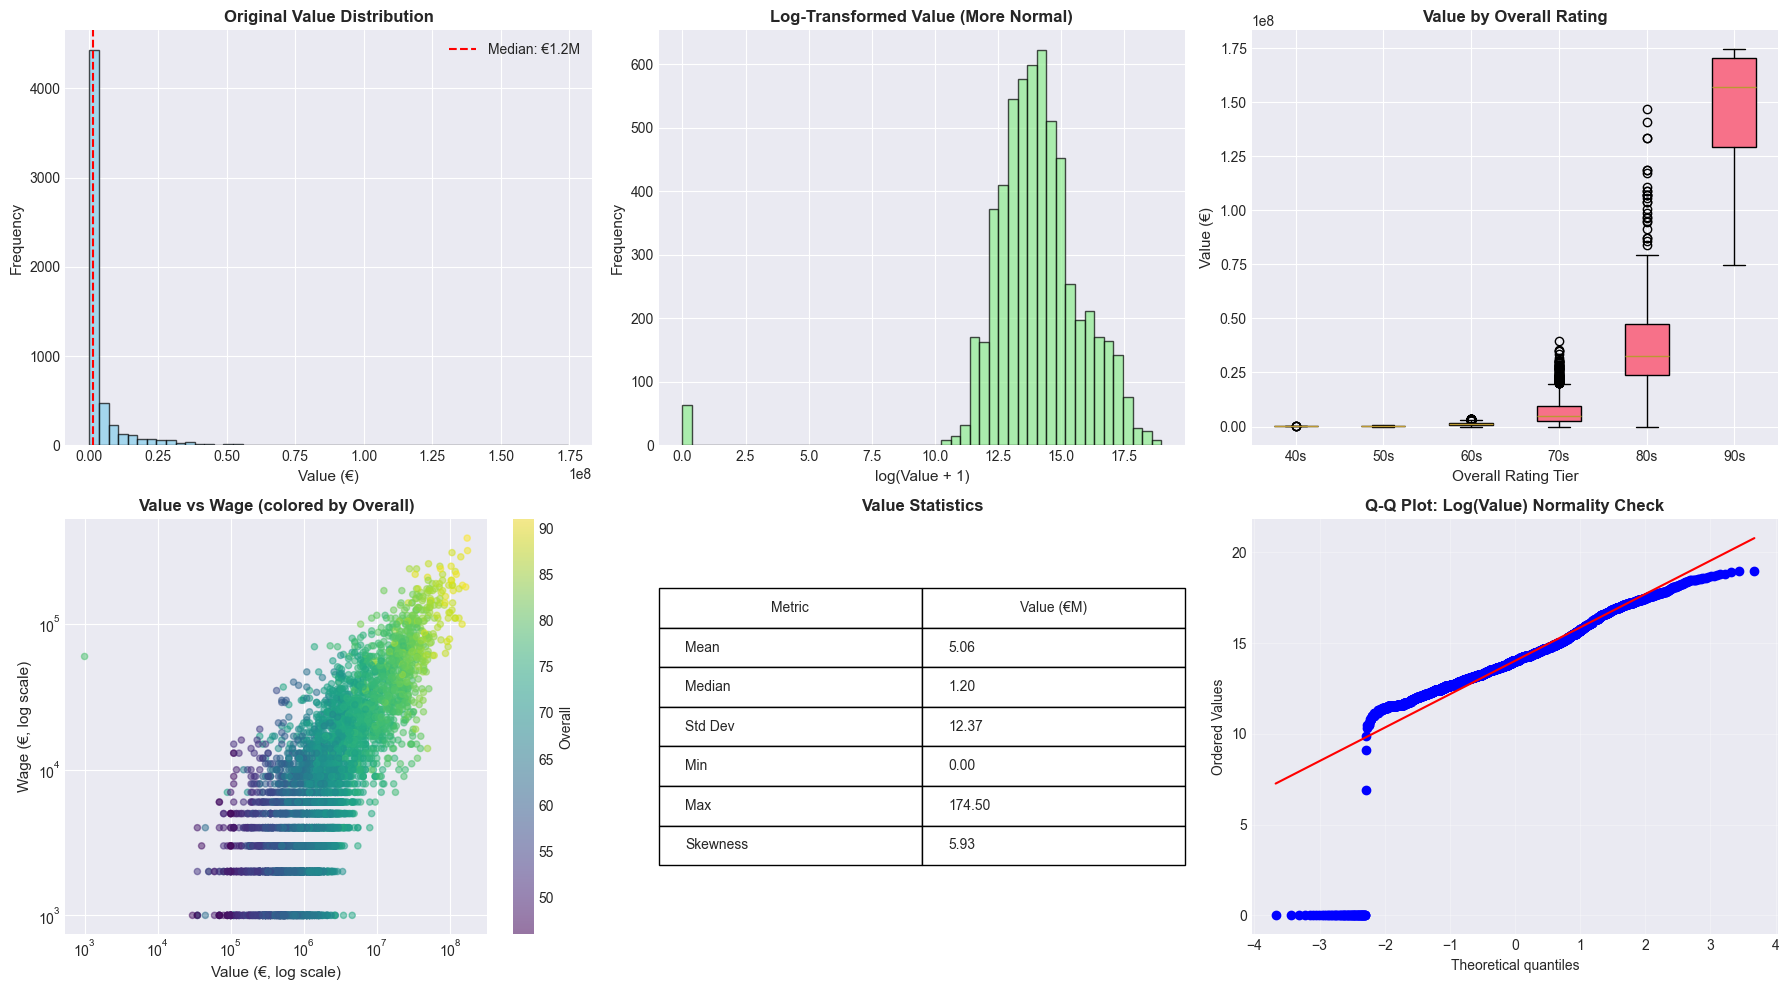

Right-skewed distribution → LOG TRANSFORMATION needed
Strong correlation with Overall rating
Value range: €0.0M - €174.5M


In [27]:
# 2. TARGET VARIABLE ANALYSIS (Value_Numeric)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Original distribution
axes[0, 0].hist(df['Value_Numeric'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Value (€)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Original Value Distribution', fontsize=12, weight='bold')
axes[0, 0].axvline(df['Value_Numeric'].median(), color='red', linestyle='--',
                    label=f"Median: €{df['Value_Numeric'].median()/1e6:.1f}M")
axes[0, 0].legend()

# Log-transformed
log_values = np.log1p(df['Value_Numeric'].dropna())
axes[0, 1].hist(log_values, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('log(Value + 1)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Log-Transformed Value (More Normal)', fontsize=12, weight='bold')

# Box plot by Overall rating tier
overall_tiers = (df['Overall'] // 10) * 10
tier_labels = sorted(overall_tiers.dropna().unique())
box_data = [df[overall_tiers == tier]['Value_Numeric'].dropna() for tier in tier_labels]
axes[0, 2].boxplot(box_data, labels=[f'{int(t)}s' for t in tier_labels], patch_artist=True)
axes[0, 2].set_xlabel('Overall Rating Tier', fontsize=11)
axes[0, 2].set_ylabel('Value (€)', fontsize=11)
axes[0, 2].set_title('Value by Overall Rating', fontsize=12, weight='bold')

# Value vs Wage (log-log)
axes[1, 0].scatter(df['Value_Numeric'], df['Wage_Numeric'],
                   c=df['Overall'], cmap='viridis', alpha=0.5, s=20)
axes[1, 0].set_xscale('log')
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Value (€, log scale)', fontsize=11)
axes[1, 0].set_ylabel('Wage (€, log scale)', fontsize=11)
axes[1, 0].set_title('Value vs Wage (colored by Overall)', fontsize=12, weight='bold')
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Overall', fontsize=10)

# Statistics table
stats_data = {
    'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skewness'],
    'Value (€M)': [
        f"{df['Value_Numeric'].mean()/1e6:.2f}",
        f"{df['Value_Numeric'].median()/1e6:.2f}",
        f"{df['Value_Numeric'].std()/1e6:.2f}",
        f"{df['Value_Numeric'].min()/1e6:.2f}",
        f"{df['Value_Numeric'].max()/1e6:.2f}",
        f"{df['Value_Numeric'].skew():.2f}"
    ]
}
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=list(zip(stats_data['Metric'], stats_data['Value (€M)'])),
                          colLabels=['Metric', 'Value (€M)'],
                          cellLoc='left', loc='center',
                          colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
axes[1, 1].set_title('Value Statistics', fontsize=12, weight='bold')

# Q-Q plot for normality check
from scipy import stats as sp_stats
sp_stats.probplot(log_values, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot: Log(Value) Normality Check', fontsize=12, weight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Right-skewed distribution → LOG TRANSFORMATION needed")
print(f"Strong correlation with Overall rating")
print(f"Value range: €{df['Value_Numeric'].min()/1e6:.1f}M - €{df['Value_Numeric'].max()/1e6:.1f}M")

**Insight:** Giá trị chuyển nhượng lệch phải mạnh, log-transform giúp chuẩn hóa; Value tăng cùng Overall/Potential và có tương quan cao với Wage, nên dùng log(Value_Numeric) làm target cho regression.

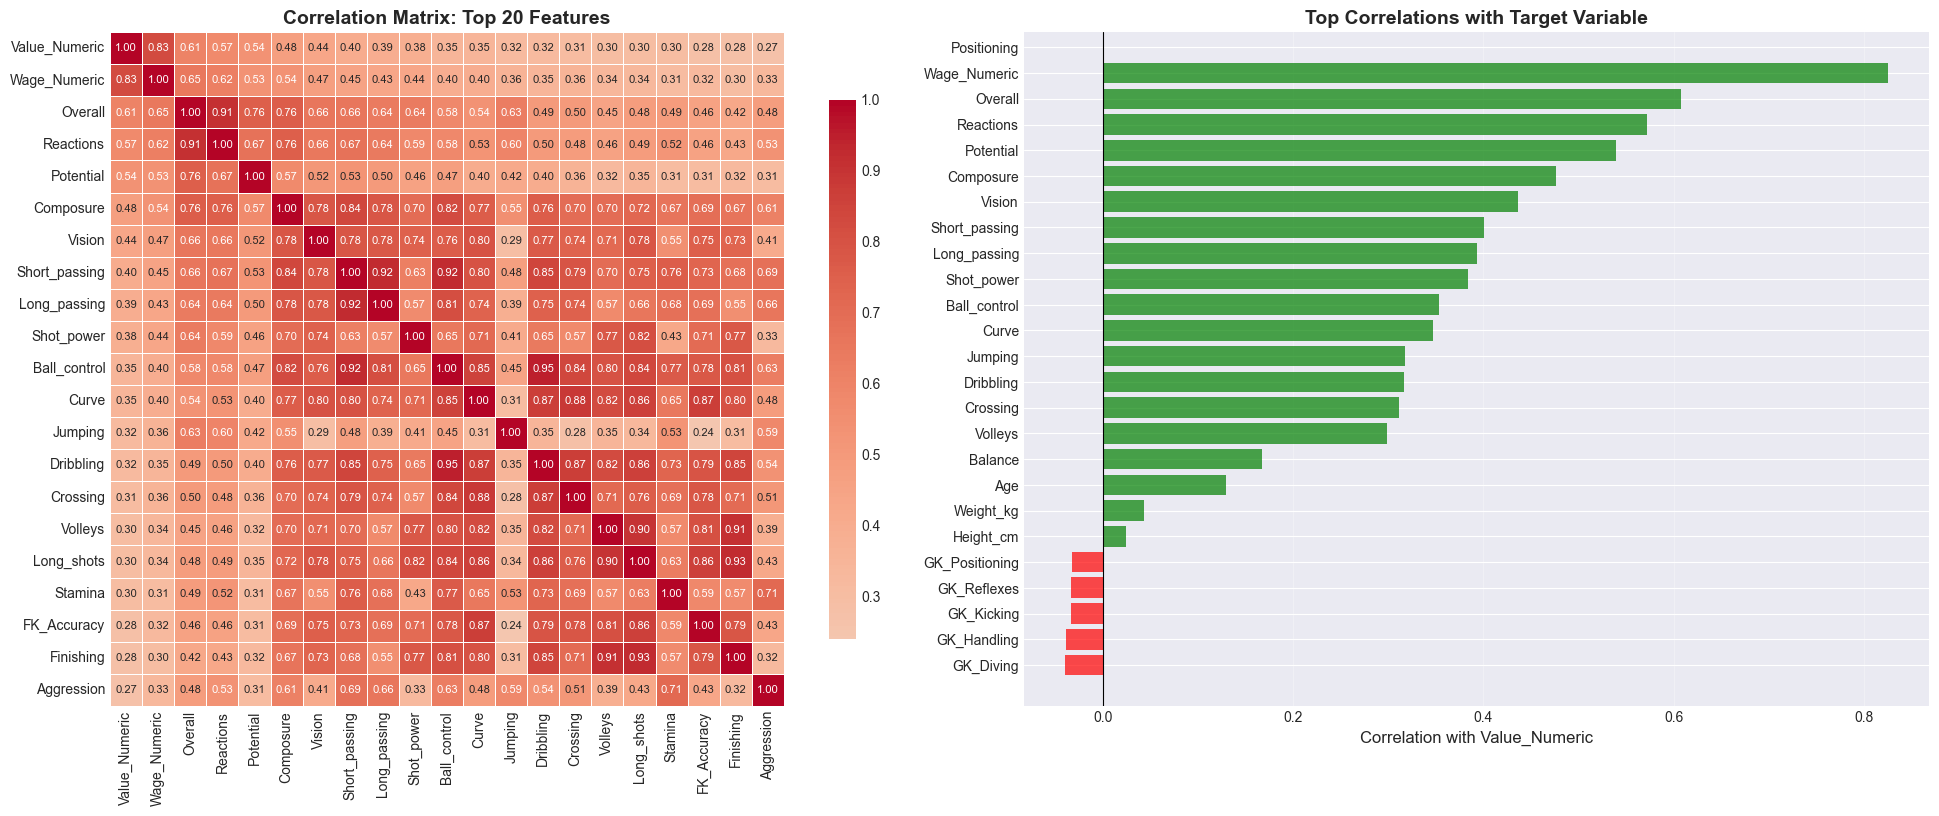


Correlation Insights:
Strongest positive correlations:
   • Wage_Numeric: 0.825
   • Overall: 0.608
   • Reactions: 0.572
   • Potential: 0.539
   • Composure: 0.477

Strongest negative correlations:
   • GK_Reflexes: -0.033
   • GK_Kicking: -0.033
   • GK_Handling: -0.039
   • GK_Diving: -0.040
   • Positioning: nan


In [28]:
# 3. CORRELATION HEATMAP - TOP FEATURES
# Select numerical columns and calculate correlations with target
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove URL and raw columns
exclude_cols = [col for col in numerical_cols if 'URL' in col or 'Raw' in col]
numerical_cols = [col for col in numerical_cols if col not in exclude_cols]

# Calculate correlation with Value_Numeric
corr_with_target = df[numerical_cols].corr()['Value_Numeric'].sort_values(ascending=False)

# Get top 20 features (including target itself)
top_features = corr_with_target.head(21).index.tolist()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation heatmap of top features
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=axes[0], annot_kws={'size': 8})
axes[0].set_title('Correlation Matrix: Top 20 Features', fontsize=14, weight='bold')

# Bar chart: Top correlations with target
top_pos = corr_with_target[1:16]  # Exclude target itself
top_neg = corr_with_target[-10:]

combined_corr = pd.concat([top_pos, top_neg]).sort_values()
colors = ['red' if x < 0 else 'green' for x in combined_corr.values]

axes[1].barh(combined_corr.index, combined_corr.values, color=colors, alpha=0.7)
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_xlabel('Correlation with Value_Numeric', fontsize=12)
axes[1].set_title('Top Correlations with Target Variable', fontsize=14, weight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
print(f"Strongest positive correlations:")
for feat, corr in corr_with_target.head(6).items():
    if feat != 'Value_Numeric':
        print(f"   • {feat}: {corr:.3f}")
print(f"\nStrongest negative correlations:")
for feat, corr in corr_with_target.tail(5).items():
    print(f"   • {feat}: {corr:.3f}")

**Insight:** Nhóm tương quan cao gồm Overall, Potential, kỹ năng kiểm soát/giữ bóng; multicollinearity hiện diện ở các cặp kỹ năng gần nhau → cần chọn lọc/bỏ bớt hoặc dùng mô hình cây.

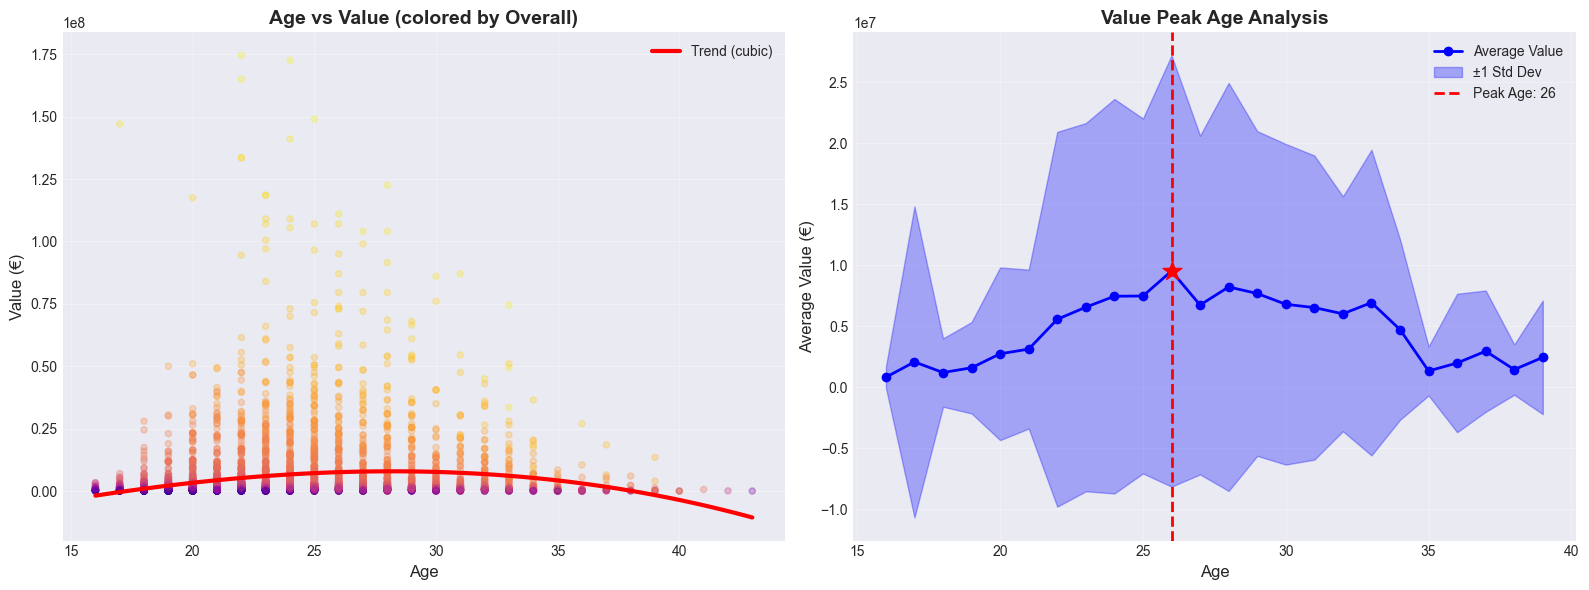

Peak value age: 26 years
Peak average value: €9.53M
Value decline starts after age 26
Investment strategy: Buy young (20-24), Sell before 30


In [29]:
# 4. AGE vs VALUE ANALYSIS (Peak Age Effect)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot with trend
axes[0].scatter(df['Age'], df['Value_Numeric'], alpha=0.3, s=20, c=df['Overall'], cmap='plasma')
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Value (€)', fontsize=12)
axes[0].set_title('Age vs Value (colored by Overall)', fontsize=14, weight='bold')
axes[0].grid(alpha=0.3)

# Add polynomial fit
age_clean = df[['Age', 'Value_Numeric']].dropna()
z = np.polyfit(age_clean['Age'], age_clean['Value_Numeric'], 3)
p = np.poly1d(z)
age_range = np.linspace(age_clean['Age'].min(), age_clean['Age'].max(), 100)
axes[0].plot(age_range, p(age_range), "r-", linewidth=3, label='Trend (cubic)')
axes[0].legend()

# Average value by age with confidence interval
age_stats = df.groupby('Age')['Value_Numeric'].agg(['mean', 'std', 'count'])
age_stats = age_stats[age_stats['count'] >= 5]  # Filter ages with few samples

axes[1].plot(age_stats.index, age_stats['mean'], 'b-', linewidth=2, marker='o',
             markersize=6, label='Average Value')
axes[1].fill_between(age_stats.index,
                      age_stats['mean'] - age_stats['std'],
                      age_stats['mean'] + age_stats['std'],
                      alpha=0.3, color='blue', label='±1 Std Dev')

# Mark peak age
peak_age = age_stats['mean'].idxmax()
peak_value = age_stats['mean'].max()
axes[1].axvline(peak_age, color='red', linestyle='--', linewidth=2,
                label=f'Peak Age: {peak_age}')
axes[1].scatter([peak_age], [peak_value], color='red', s=200, zorder=5, marker='*')

axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Average Value (€)', fontsize=12)
axes[1].set_title('Value Peak Age Analysis', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Peak value age: {peak_age} years")
print(f"Peak average value: €{peak_value/1e6:.2f}M")
print(f"Value decline starts after age {peak_age}")
print(f"Investment strategy: Buy young (20-24), Sell before 30")

**Insight:** Giá trị đạt đỉnh quanh mid-20s; trẻ (<=21) có khoảng cách Potential-Overall lớn → upside cao; sau 29 giá trị giảm dần, gợi ý chiến lược mua sớm, bán trước giai đoạn suy giảm.

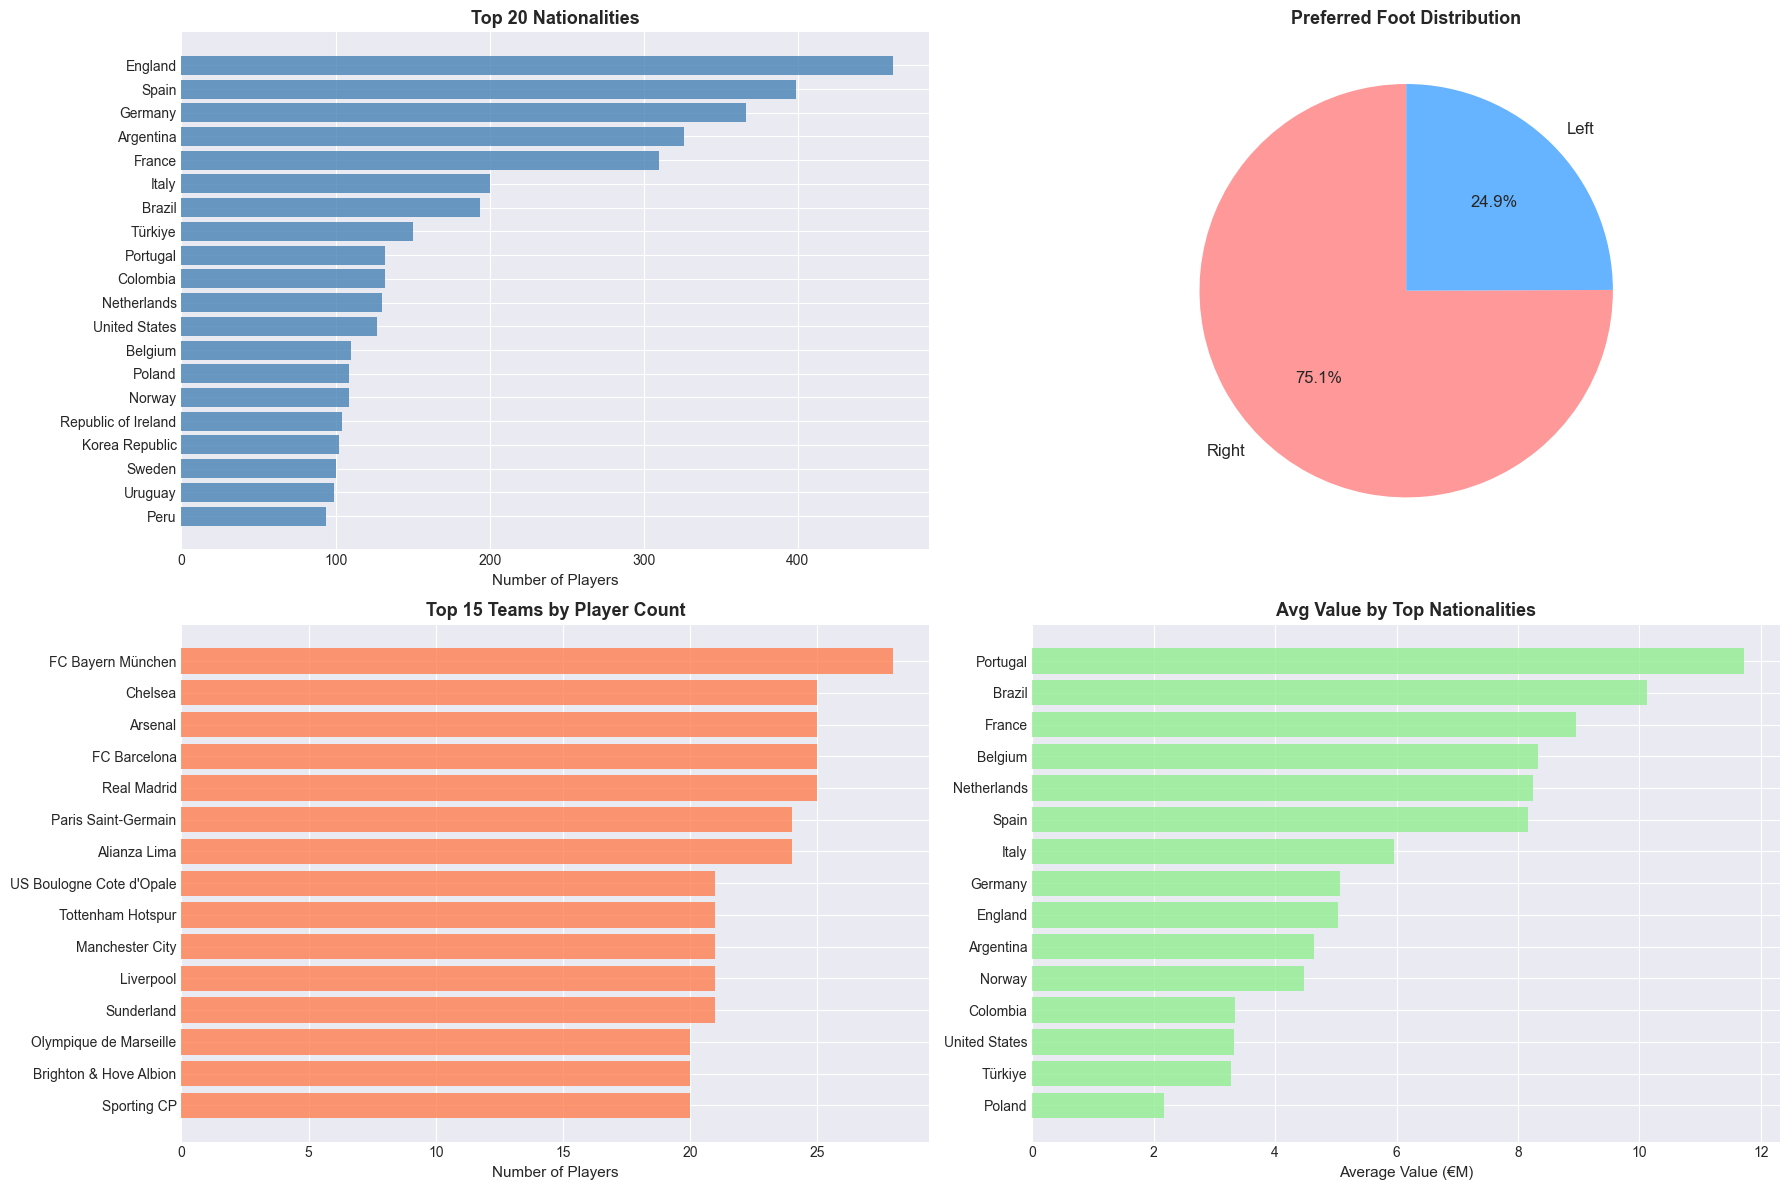

Total nationalities: 138
Right-footed players: 75.0%
Total teams: 828
Most valuable nationality: Portugal (€11.7M avg)


In [30]:
# 5. CATEGORICAL FEATURES ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 20 Nationalities
top_nations = df['Nationality'].value_counts().head(20)
axes[0, 0].barh(top_nations.index, top_nations.values, color='steelblue', alpha=0.8)
axes[0, 0].set_xlabel('Number of Players', fontsize=11)
axes[0, 0].set_title('Top 20 Nationalities', fontsize=13, weight='bold')
axes[0, 0].invert_yaxis()

# Preferred Foot Distribution
foot_counts = df['Preferred_Foot'].value_counts()
colors_pie = ['#ff9999', '#66b3ff']
axes[0, 1].pie(foot_counts.values, labels=foot_counts.index, autopct='%1.1f%%',
               startangle=90, colors=colors_pie, textprops={'fontsize': 12})
axes[0, 1].set_title('Preferred Foot Distribution', fontsize=13, weight='bold')

# Top 15 Teams
top_teams = df['Team'].value_counts().head(15)
axes[1, 0].barh(top_teams.index, top_teams.values, color='coral', alpha=0.8)
axes[1, 0].set_xlabel('Number of Players', fontsize=11)
axes[1, 0].set_title('Top 15 Teams by Player Count', fontsize=13, weight='bold')
axes[1, 0].invert_yaxis()

# Average Value by Top Nationalities
top_nation_names = top_nations.head(15).index
nation_avg_value = df[df['Nationality'].isin(top_nation_names)].groupby('Nationality')['Value_Numeric'].mean().sort_values(ascending=False)
axes[1, 1].barh(nation_avg_value.index, nation_avg_value.values/1e6, color='lightgreen', alpha=0.8)
axes[1, 1].set_xlabel('Average Value (€M)', fontsize=11)
axes[1, 1].set_title('Avg Value by Top Nationalities', fontsize=13, weight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"Total nationalities: {df['Nationality'].nunique()}")
print(f"Right-footed players: {foot_counts.get('Right', 0) / len(df) * 100:.1f}%")
print(f"Total teams: {df['Team'].nunique()}")
print(f"Most valuable nationality: {nation_avg_value.index[0]} (€{nation_avg_value.iloc[0]/1e6:.1f}M avg)")

**Insight:** Chân thuận phải chiếm đa số; một số quốc tịch/CLB có premium rõ (big clubs); phân bổ vị trí/nationality lệch → khi encode cần xử lý high-cardinality (Nationality/Team) bằng label/target encoding.

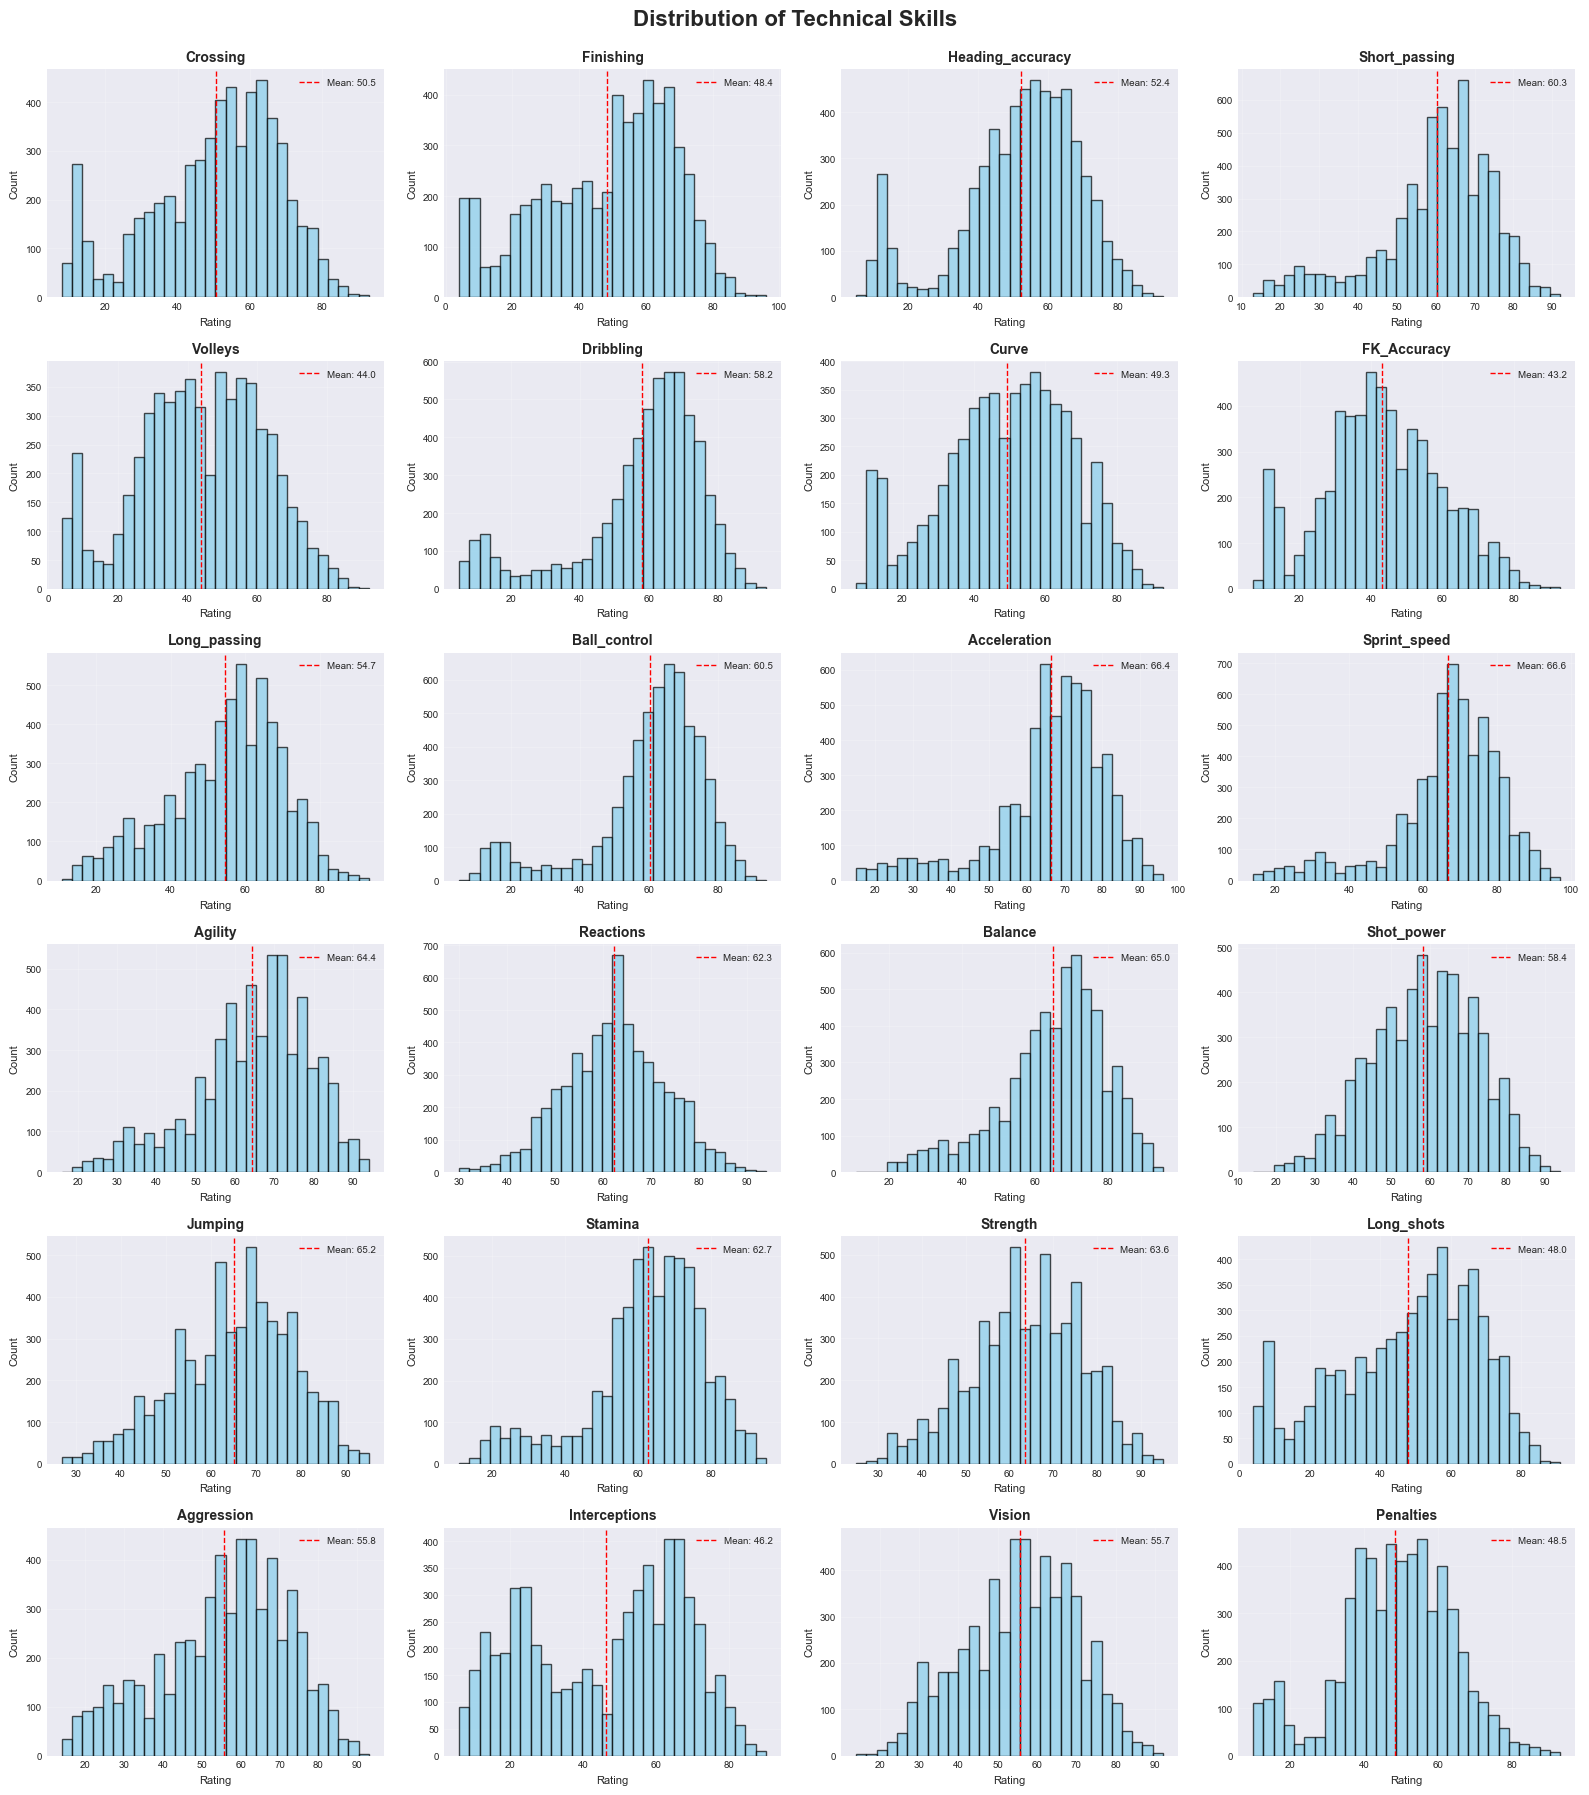

Most skills follow approximately normal distribution
Mean ratings typically 50-70 range
GK skills likely show bimodal distribution (goalkeepers vs outfield)


In [31]:
# 6. SKILL DISTRIBUTIONS - GRID PLOT
skill_cols = ['Crossing', 'Finishing', 'Heading_accuracy', 'Short_passing', 'Volleys',
              'Dribbling', 'Curve', 'FK_Accuracy', 'Long_passing', 'Ball_control',
              'Acceleration', 'Sprint_speed', 'Agility', 'Reactions', 'Balance',
              'Shot_power', 'Jumping', 'Stamina', 'Strength', 'Long_shots',
              'Aggression', 'Interceptions', 'Vision', 'Penalties']

fig, axes = plt.subplots(6, 4, figsize=(16, 18))
axes = axes.flatten()

for idx, col in enumerate(skill_cols):
    if col in df.columns:
        data = df[col].dropna()
        axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[idx].set_title(f'{col}', fontsize=10, weight='bold')
        axes[idx].set_xlabel('Rating', fontsize=8)
        axes[idx].set_ylabel('Count', fontsize=8)
        axes[idx].axvline(data.mean(), color='red', linestyle='--', linewidth=1,
                          label=f'Mean: {data.mean():.1f}')
        axes[idx].legend(fontsize=7)
        axes[idx].grid(alpha=0.2)
        axes[idx].tick_params(labelsize=7)

# Hide unused subplots
for idx in range(len(skill_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of Technical Skills', fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"Most skills follow approximately normal distribution")
print(f"Mean ratings typically 50-70 range")
print(f"GK skills likely show bimodal distribution (goalkeepers vs outfield)")

**Insight:** Phần lớn kỹ năng phân bố gần chuẩn 50-70; kỹ năng GK có thể bimodal do outfield vs GK → tách mô hình hoặc tạo composite skill (Pace, Shooting, Passing...) để giảm nhiễu.

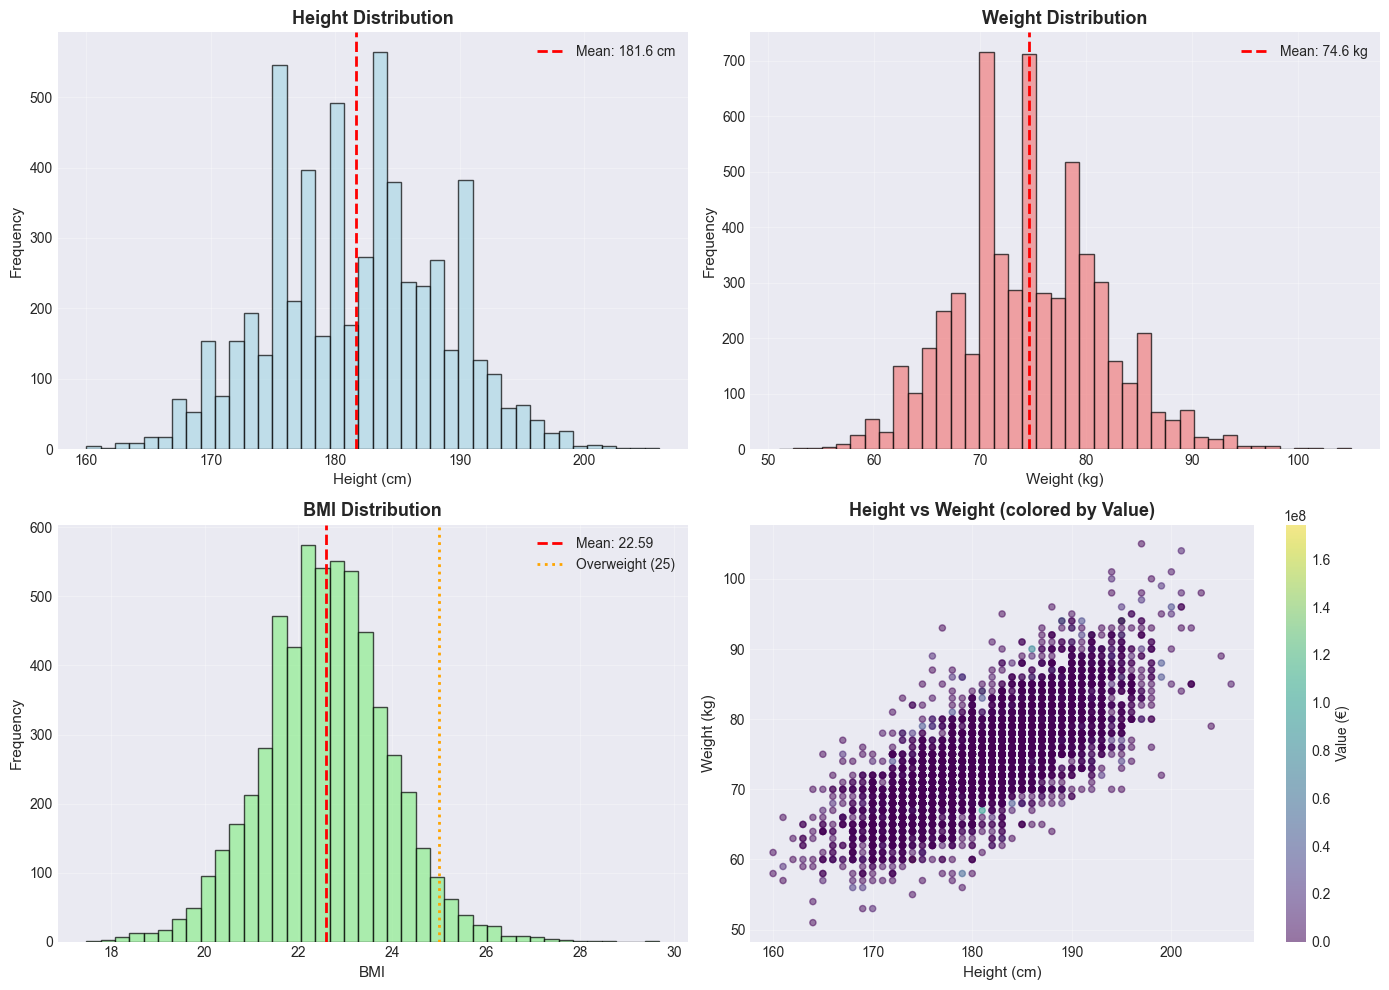

Average height: 181.6 cm
Average weight: 74.6 kg
Average BMI: 22.59
BMI range: Athletes typically have 20-25 BMI


In [32]:
# 7. PHYSICAL ATTRIBUTES ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Height distribution
axes[0, 0].hist(df['Height_cm'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='lightblue')
axes[0, 0].axvline(df['Height_cm'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f"Mean: {df['Height_cm'].mean():.1f} cm")
axes[0, 0].set_xlabel('Height (cm)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Height Distribution', fontsize=13, weight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Weight distribution
axes[0, 1].hist(df['Weight_kg'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].axvline(df['Weight_kg'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f"Mean: {df['Weight_kg'].mean():.1f} kg")
axes[0, 1].set_xlabel('Weight (kg)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Weight Distribution', fontsize=13, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# BMI calculation and distribution
df_temp = df.copy()
df_temp['BMI'] = df_temp['Weight_kg'] / ((df_temp['Height_cm']/100) ** 2)
axes[1, 0].hist(df_temp['BMI'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].axvline(df_temp['BMI'].mean(), color='red', linestyle='--', linewidth=2,
                    label=f"Mean: {df_temp['BMI'].mean():.2f}")
axes[1, 0].axvline(25, color='orange', linestyle=':', linewidth=2, label='Overweight (25)')
axes[1, 0].set_xlabel('BMI', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('BMI Distribution', fontsize=13, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Height vs Weight scatter
scatter = axes[1, 1].scatter(df['Height_cm'], df['Weight_kg'],
                             c=df['Value_Numeric'], cmap='viridis',
                             alpha=0.5, s=20)
axes[1, 1].set_xlabel('Height (cm)', fontsize=11)
axes[1, 1].set_ylabel('Weight (kg)', fontsize=11)
axes[1, 1].set_title('Height vs Weight (colored by Value)', fontsize=13, weight='bold')
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Value (€)', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Average height: {df['Height_cm'].mean():.1f} cm")
print(f"Average weight: {df['Weight_kg'].mean():.1f} kg")
print(f"Average BMI: {df_temp['BMI'].mean():.2f}")
print(f"BMI range: Athletes typically have 20-25 BMI")

**Insight:** Chiều cao/cân nặng tập trung quanh mức trung bình; BMI trong ngưỡng vận động viên, tương quan yếu với Value → giữ làm đặc trưng phụ, hữu ích hơn cho nhóm GK/CB.

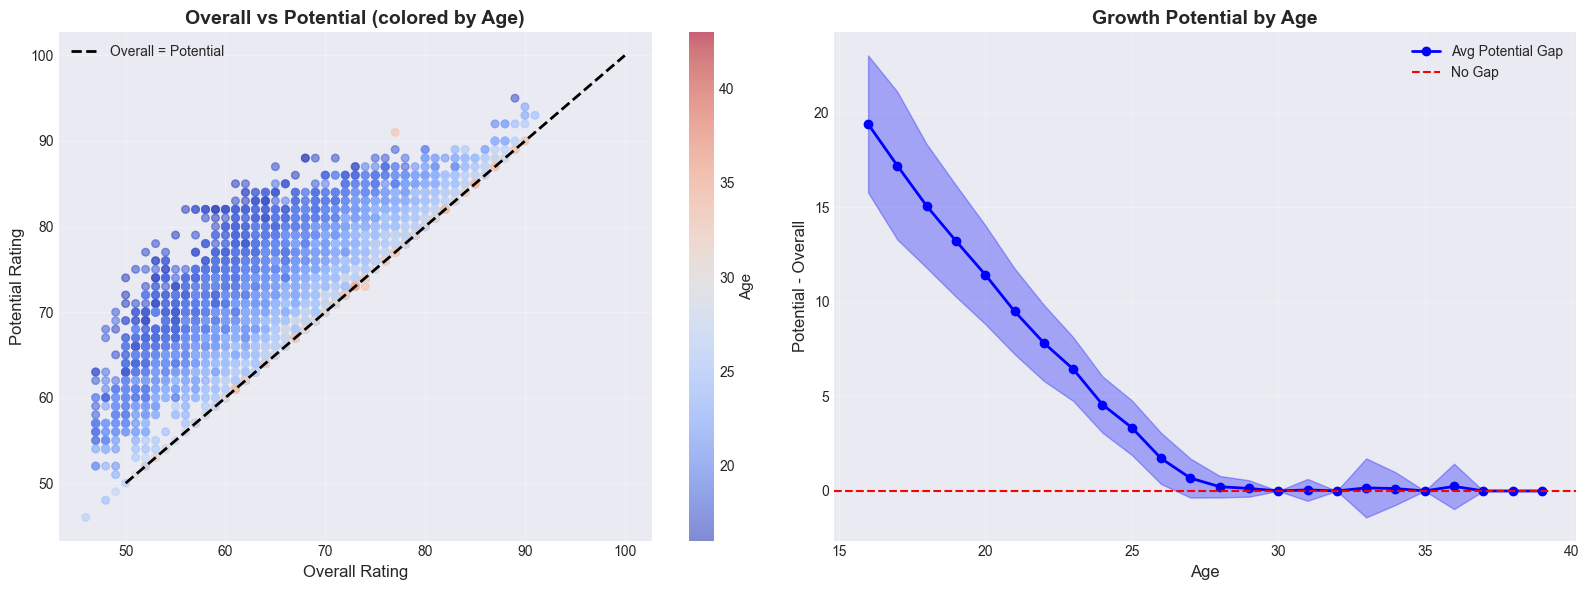


⭐ Young Talents (Age ≤21, Potential ≥85):
          Name  Age  Overall  Potential  Value_Numeric                Team
  Lamine Yamal   17       89         95    147000000.0        FC Barcelona
    João Neves   20       87         92    117500000.0 Paris Saint-Germain
      Nico Paz   20       80         89     46500000.0                Como
     K. Yıldız   20       80         89     46500000.0            Juventus
  Rodrigo Mora   18       77         89     24500000.0            FC Porto
W. Zaïre-Emery   19       81         88     50000000.0 Paris Saint-Germain
       L. Karl   17       71         88      4700000.0   FC Bayern München
   V. Froholdt   19       78         88     30000000.0            FC Porto
     C. Varela   16       68         88      3300000.0       Dinamo Zagreb
      J. Mokio   17       69         88      3300000.0                Ajax
   • Young players (16-20): Highest growth potential
   • Peak age (~27): Potential ≈ Overall (reached potential)
   • Older players

In [33]:
# 8. OVERALL vs POTENTIAL ANALYSIS
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
scatter = axes[0].scatter(df['Overall'], df['Potential'],
                          c=df['Age'], cmap='coolwarm',
                          alpha=0.6, s=30)
axes[0].plot([50, 100], [50, 100], 'k--', linewidth=2, label='Overall = Potential')
axes[0].set_xlabel('Overall Rating', fontsize=12)
axes[0].set_ylabel('Potential Rating', fontsize=12)
axes[0].set_title('Overall vs Potential (colored by Age)', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Age', fontsize=11)

# Potential - Overall difference by Age
df_temp['Potential_Gap'] = df_temp['Potential'] - df_temp['Overall']
age_groups = df_temp.groupby('Age')['Potential_Gap'].agg(['mean', 'std', 'count'])
age_groups = age_groups[age_groups['count'] >= 5]

axes[1].plot(age_groups.index, age_groups['mean'], 'b-', linewidth=2,
             marker='o', markersize=6, label='Avg Potential Gap')
axes[1].fill_between(age_groups.index,
                      age_groups['mean'] - age_groups['std'],
                      age_groups['mean'] + age_groups['std'],
                      alpha=0.3, color='blue')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1.5, label='No Gap')
axes[1].set_xlabel('Age', fontsize=12)
axes[1].set_ylabel('Potential - Overall', fontsize=12)
axes[1].set_title('Growth Potential by Age', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find highest potential young players
young_talents = df_temp[(df_temp['Age'] <= 21) & (df_temp['Potential'] >= 85)].sort_values('Potential', ascending=False)
print(f"\n⭐ Young Talents (Age ≤21, Potential ≥85):")
if len(young_talents) > 0:
    print(young_talents[['Name', 'Age', 'Overall', 'Potential', 'Value_Numeric', 'Team']].head(10).to_string(index=False))
else:
    print("No young talents found in sample")

print(f"   • Young players (16-20): Highest growth potential")
print(f"   • Peak age (~27): Potential ≈ Overall (reached potential)")
print(f"   • Older players (30+): Potential < Overall (declining)")

**Insight:** Khoảng cách Potential-Overall nổi bật ở cầu thủ trẻ; khi tới đỉnh (≈27) hai giá trị hội tụ; insight hỗ trợ scouting: ưu tiên cầu thủ có gap lớn và Overall đã khá để tối ưu ROI.